<a href="https://colab.research.google.com/github/Gus-1003/ISD-invention/blob/main/Pesquisa/5_Valida%C3%A7%C3%A3o_Modularizada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando Bibliotecas

In [1]:
import os

import glob

import cv2

import numpy as np

import math

import pandas as pd

import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

from google.colab import drive

drive.mount('/content/drive/')

%cd /content/drive/MyDrive/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive


# Funções:

## Calcular_Distancia

In [2]:
def calcular_distancia(x1, y1, x2, y2):
  # Calcula a diferença entre as coordenadas x e y
  diff_x = x2 - x1
  diff_y = y2 - y1

  # Calcula o quadrado das diferenças
  diff_x_squared = diff_x ** 2
  diff_y_squared = diff_y ** 2

  # Calcula a soma dos quadrados das diferenças
  sum_diff_squared = diff_x_squared + diff_y_squared

  # Calcula a raiz quadrada da soma dos quadrados das diferenças
  distancia = math.sqrt(sum_diff_squared)

  return distancia

## Create_Dataset:

In [3]:
def create_dataset_image(dataset):
  # Cria uma lista vazia para armazenar os objetos
  objects = []

  # Percorre o dicionário
  for attr, obj_list in dataset.items():
    # Percorre a lista de objetos para o atributo atual
    for obj in obj_list:
      # Verifica se obj é um dicionário
      if isinstance(obj, dict):
        # Adiciona o objeto combinando com o dicionário {'attribute': attr}
        objects.append({**{'attribute': attr}, **obj})

  # Cria o DataFrame com base na lista de objetos
  df = pd.DataFrame(objects)

  # Retorna o DataFrame se for necessário usá-lo posteriormente
  return df

## calculate_contour_properties:

In [4]:
def calculate_contour_properties(cnt):
  # Momentos do objeto
  M = cv2.moments(cnt)

  # Calcula a área do contorno
  area = cv2.contourArea(cnt)

  # Calcula o perímetro do contorno
  perimeter = cv2.arcLength(cnt, True)

  # Proporção de aspecto do objeto
  x,y,w,h = cv2.boundingRect(cnt)
  width = w
  height = h

  if min(w, h) == 0:
    aspect_ratio = 0
  else:
    aspect_ratio = max(float(w), h) / min(float(w), h)

  # Ângulo e raio mínimo envolvente em torno do objeto
  rect = cv2.minAreaRect(cnt)
  circle = cv2.minEnclosingCircle(cnt)

  box = cv2.boxPoints(rect)
  box = np.int0(box)

  # Extensão do objeto (razão entre a área do objeto e a área do retângulo envolvente mínimo)
  rect_area = w*h

  # Forma de achar o contorno 1
  center_x = int(M["m10"] / M["m00"])
  center_y = int(M["m01"] / M["m00"])

  # Forma de achar o contorno 2 - Circulo
  (x_circle, y_circle), radius = cv2.minEnclosingCircle(cnt)
  center_circle = (int(x_circle), int(y_circle))
  cx_circle = int(x_circle)
  cy_circle = int(y_circle)

  # Forma de achar o contorno 2 - Quadrado
  cx_quad = int(x)
  cy_quad = int(y)

  # Calcula a circularidade do contorno
  if perimeter > 0:
      circularity = 4 * np.pi * area / (perimeter ** 2)
  else:
      circularity = 0
      
  return area, circularity, radius, x, y, w, h, aspect_ratio, box, center_circle, cx_circle, cy_circle, cx_quad, cy_quad, center_x, center_y

## process_contours:

In [5]:
def process_contours(nome_frame, img_contours, contours, imagem_original):

  objetos = 0
  dicionario = {}  # Dicionário para armazenar os dados dos objetos identificados

  for cnt in contours:
    # Aproxima o contorno por uma sequência de segmentos de linha
    approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)

    # Calcula as propriedades do contorno
    area, circularity, radius, x, y, w, h, aspect_ratio, box, center, cx_circle, cy_circle, cx_quad, cy_quad, center_x, center_y = calculate_contour_properties(cnt)

    x1 = 204
    y1 = 253  

    if objetos == 1:
      x1 = 444
      y1 = 243


    # Para um padrão Circular:
    if circularity > 0.30 and area > 2000 and radius < 100 and radius > 20:

      # Define o raio máximo desejado
      max_radius = 100

      # Limita o raio ao valor máximo
      radius = min(radius, max_radius)

      # Converte o raio para inteiro
      radius = int(radius)

      # Calcula as Distancias entre os pontos centrais
      distance_green_blue = calcular_distancia(cx_circle, cy_circle, center_x, center_y)

      # Calcula as Distancias entre os pontos centrais
      distance_red_blue = calcular_distancia(x1, y1, center_x, center_y)
      distance_red_green = calcular_distancia(x1, y1, cx_circle, cy_circle)

      # Desenha um contorno Circular
      cv2.circle(img_contours, center, radius, (0, 255, 0), 2)
      
      # Desenho do ponto central
      cv2.circle(img_contours, (cx_circle, cy_circle), 3, (0, 255, 0), -1) # Verde - minEnclosingCircle
      cv2.circle(img_contours, (center_x, center_y), 3, (255, 0, 0), -1) # Azul - Momentun

      # Desenha uo ponto central ideal
      cv2.circle(img_contours, (x1, y1), 3, (0, 0, 255), -1) # Vermelho - Ideal

      # Contagem total de Objetos Identificados
      objetos = objetos + 1

      # Captura dos dados:
      dicionario[f"{nome_frame}_{objetos}"] = []
      # Adicione os dados desejados ao dicionário dataset
      dicionario[f"{nome_frame}_{objetos}"].append({
        "Form": "circle",
        "area": area,
        "circularity": circularity,
        "radius": radius,
        "x": x,
        "y": y,
        "w": w,
        "h": h,
        "cx_circle": cx_circle,
        "cy_circle": cy_circle,
        "cx_momentun": center_x,
        "cy_momentun": center_y,
        "cx_vermelho": x1,
        "cy_vermelho": y1,
        "distance_green_blue" : distance_green_blue,
        "distance_red_blue" : distance_red_blue,
        "distance_red_green" : distance_red_green,
      })


    else:
      if aspect_ratio < 2 and area > 2000 and area < 6543.5: 
        # Calcula as Distancias entre os pontos centrais
        distance_blue_green = calcular_distancia(cx_circle, cy_circle, center_x, center_y)

        # Calcula as Distancias entre os pontos centrais
        distance_blue = calcular_distancia(x1, y1, center_x, center_y)
        distance_green = calcular_distancia(x1, y1, cx_quad, cy_quad)

        # Desenha um contorno quadratico
        cv2.drawContours(img_contours, [box], 0, (0, 255, 0), 2)

        # Desenho do ponto central
        cv2.circle(img_contours, (cx_circle, cy_circle), 3, (0, 255, 0), -1) # verde - minEnclosingCircle
        cv2.circle(img_contours, (center_x, center_y), 3, (255, 0, 0), -1) # Azul - Momentun
        
        # Desenha uo pont0 central ideal
        cv2.circle(img_contours, (x1, y1), 3, (0, 0, 255), -1) # Vermelho - Ideal

        # Contagem total de Objetos Identificados
        objetos = objetos + 1
        dicionario[f"{nome_frame}_{objetos}"] = []
        dicionario[f"{nome_frame}_{objetos}"].append({
          "Form": "Não Circular",
          "area": area,
          "circularity": circularity,
          "radius": radius,
          "x": x,
          "y": y,
          "w": w,
          "h": h,
          "cx_circle": cx_circle,
          "cy_circle": cy_circle,
          "cx_momentun": center_x,
          "cx_momentun": center_y,
          "cx_vermelho": x1,
          "cy_vermelho": y1,
          "distance_green_blue" : distance_green_blue,
          "distance_red_blue" : distance_red_blue,
          "distance_red_green" : distance_red_green,
        })

  return imagem_original, objetos, dicionario

## find_contours:

In [6]:
def find_contours(image):
  # Encontra os contornos na imagem
  contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  return contours

## dilate_image:

In [7]:
def dilate_image(image):
  # Define o kernel para a dilatação
  kernel = np.ones((5, 5), np.uint8)

  # Dilata a imagem
  image = cv2.dilate(image, kernel, iterations=2)
  return image

## apply_threshold:

In [8]:
def apply_threshold(image):
  # Aplica um filtro de Sobel em x e y
  sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

  # Calcula a magnitude do gradiente
  gradient_magnitude = cv2.magnitude(sobelx, sobely)

  # Normaliza a magnitude do gradiente
  gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

  # Aplica uma limiarização utilizando o método de Otsu
  _, gradient_threshold = cv2.threshold(gradient_magnitude, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  
  return gradient_threshold

## apply_filters:

In [9]:
def apply_filters(image):
  # Converte a imagem para float32
  image32f = np.float32(image)
  
  # Aplica um filtro de média
  mu = cv2.blur(image32f, (3, 3))

  # Calcula a variância da imagem filtrada
  mu2 = cv2.blur(image32f * image32f, (3, 3))
  sigma = cv2.sqrt(mu2 - mu * mu)
  sigma = sigma * 10
  sigma = sigma.astype("uint8")

  # Aplica um filtro de borramento Gaussiano
  sigma = cv2.GaussianBlur(sigma, (5, 5), 0)

  # Aplica o filtro Laplaciano
  laplacian = cv2.Laplacian(sigma, cv2.CV_32F)

  # Converte a saída para o intervalo de 0 a 255
  sigma = cv2.convertScaleAbs(laplacian)

  return sigma

## print_frame_info:

In [10]:
def print_frame_info(nome):
  # Imprime informações do frame
  print(f"================================================================================")
  print(f"================================================================================")
  print(f"Amostra: " + nome)

## process_frame:

In [11]:
def process_frame(frame):
  # Carrega a imagem
  im = cv2.imread(frame)
  
  # Divide o caminho do arquivo e obtém o nome do frame
  nome_completo = frame.split('/')
  nome = nome_completo[int(posicao_do_nome_frame)].split('.')
  amostra = nome[0]

  # Imprime informações do frame
  print_frame_info(amostra)

  # Cria uma cópia da imagem para desenhar os contornos
  img_contours = im.copy()

  # Converte a imagem para escala de cinza
  image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

  # Aplica uma série de filtros à imagem
  sigma = apply_filters(image)

  # Aplica uma limiarização à imagem filtrada
  gradient_threshold = apply_threshold(sigma)

  # Dilata a imagem limiarizada
  gradient_threshold = dilate_image(gradient_threshold)

  # Encontra os contornos na imagem dilatada
  contours = find_contours(gradient_threshold)

  # Processa cada contorno encontrado
  resultados = process_contours(amostra, img_contours, contours, img_contours)

  return resultados, amostra

# Base do Sistema:

## Endereço da imagem:

In [12]:
destino = '/content/drive/MyDrive/Pesquisa_ISD_IC/Validação/'

### Imagem Alvo:

In [13]:
frame = '/content/drive/MyDrive/Pesquisa_ISD_IC/Validação/Dia2-Explo-CCF504-Contexto4.jpg'

In [14]:
posicao_do_nome_frame = input("posicao do nome da Imagem:") #6

posicao do nome da Imagem:6


# Algoritmo Principal:

In [ ]:
resultados, amostra = process_frame(frame)

# Imprime o número de objetos encontrados
print(resultados[1])

# Exibe a imagem com os contornos encontrados
cv2_imshow(resultados[0])

output_path = os.path.join(destino, f"{amostra}_bteste.jpg")

# Salvar a imagem resultante
cv2.imwrite(output_path, resultados[0])

# Chama a função create_dataset com o dataset gerado
dados = create_dataset_image(resultados[2])

# Salva o DataFrame em um arquivo CSV
dados.to_csv(output_path + "data", index=False)

In [31]:
resultados[0].shape

(480, 640, 3)

ImageJ na imagem: Dia2-Explo-CCF504-Contexto4 = (640, 480, 3)

As duas representações estão invertendo a ordem das dimensões da imagem em relação a altura e largura.

No caso da notação "Python: (480, 640, 3)", os valores representam:

480: A altura da imagem em pixels.
640: A largura da imagem em pixels.
3: O número de canais de cores da imagem (normalmente, vermelho, verde e azul).
Na notação "ImageJ: (640, 480, 3)", ocorre a inversão das dimensões, então temos:

640: A largura da imagem em pixels.
480: A altura da imagem em pixels.
3: O número de canais de cores da imagem.
A diferença entre as ordens das dimensões pode ocorrer por diferentes convenções adotadas pelos softwares ou bibliotecas ao representar a imagem. É importante observar que a ordem das dimensões não afeta o conteúdo visual da imagem, apenas a forma como ela é interpretada e exibida pelos programas.

# Mineração dos Dados:

In [16]:
dados

,attribute,Form,area,circularity,radius,x,y,w,h,cx_circle,cy_circle,cx_momentun,cy_momentun,cx_vermelho,cy_vermelho,distance_green_blue,distance_red_blue,distance_red_green
0,Dia2-Explo-CCF504-Contexto4_1,circle,3474.0,0.816731,36,412,211,66,66,442,240,444,243,204,253,3.605551,240.208243,238.354778
1,Dia2-Explo-CCF504-Contexto4_2,circle,5015.0,0.656527,47,166,199,81,93,204,244,204,249,444,243,5.000000,240.074988,240.002083


In [22]:
# Dicionário com os dados de todas as imagens
#dados_gerais = {}

# Chama a função create_dataset_image com o dicionário completo de todas as imagens
dataset_geral = create_dataset_image(resultados[2])

# Salva o DataFrame em um arquivo CSV
dataset_geral.to_csv(destino + "_dataset_geral.csv", index=False)

In [23]:
dataset_geral

,attribute,Form,area,circularity,radius,x,y,w,h,cx_circle,cy_circle,cx_momentun,cy_momentun,cx_vermelho,cy_vermelho,distance_green_blue,distance_red_blue,distance_red_green
0,Dia2-Explo-CCF504-Contexto4_1,circle,3474.0,0.816731,36,412,211,66,66,442,240,444,243,204,253,3.605551,240.208243,238.354778
1,Dia2-Explo-CCF504-Contexto4_2,circle,5015.0,0.656527,47,166,199,81,93,204,244,204,249,444,243,5.000000,240.074988,240.002083


In [24]:
dataset_geral.describe()

,area,circularity,radius,x,y,w,h,cx_circle,cy_circle,cx_momentun,cy_momentun,cx_vermelho,cy_vermelho,distance_green_blue,distance_red_blue,distance_red_green
count,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,4244.50000,0.736629,41.500000,289.000000,205.000000,73.500000,79.500000,323.000000,242.000000,324.000000,246.000000,324.000000,248.000000,4.302776,240.141616,239.178430
std,1089.65155,0.113282,7.778175,173.948268,8.485281,10.606602,19.091883,168.291414,2.828427,169.705627,4.242641,169.705627,7.071068,0.986024,0.094225,1.164821
min,3474.00000,0.656527,36.000000,166.000000,199.000000,66.000000,66.000000,204.000000,240.000000,204.000000,243.000000,204.000000,243.000000,3.605551,240.074988,238.354778
25%,3859.25000,0.696578,38.750000,227.500000,202.000000,69.750000,72.750000,263.500000,241.000000,264.000000,244.500000,264.000000,245.500000,3.954163,240.108302,238.766604
50%,4244.50000,0.736629,41.500000,289.000000,205.000000,73.500000,79.500000,323.000000,242.000000,324.000000,246.000000,324.000000,248.000000,4.302776,240.141616,239.178430
75%,4629.75000,0.776680,44.250000,350.500000,208.000000,77.250000,86.250000,382.500000,243.000000,384.000000,247.500000,384.000000,250.500000,4.651388,240.174929,239.590257
max,5015.00000,0.816731,47.000000,412.000000,211.000000,81.000000,93.000000,442.000000,244.000000,444.000000,249.000000,444.000000,253.000000,5.000000,240.208243,240.002083


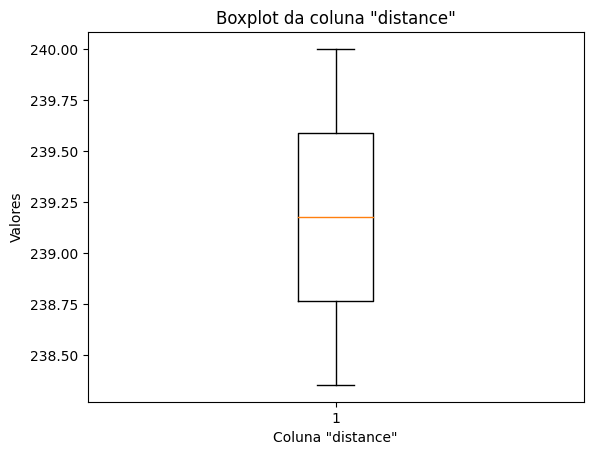

In [19]:
# Acesse a coluna "distance" do DataFrame
coluna_distance = dataset_geral['distance_red_green']

# Crie um boxplot da coluna "distance"
plt.boxplot(coluna_distance)

# Adicione rótulos e título ao gráfico
plt.xlabel('Coluna "distance"')
plt.ylabel('Valores')
plt.title('Boxplot da coluna "distance"')

# Exiba o gráfico
plt.show()

In [20]:
qtd_amostras = coluna_distance.count()

# Defina o limiar
limiar = 10

# Area de interesse:
ideais = 3

# Conte o número de amostras que são superiores ao limiar
contador = np.sum(coluna_distance > limiar)

# Conte o número de amostras que são superiores ao limiar
desejo = np.sum(coluna_distance < ideais)

# Imprima o resultado
print(f"temos ({qtd_amostras}) amostras no total.")

# Imprima o resultado
print(f"Número de amostras acima ({limiar}) unidades de distancia: {contador}")

# Imprima o resultado
print(f"Número de amostras abixo de ({ideais}) unidades de distancia: {desejo}")

temos (2) amostras no total.
Número de amostras acima (10) unidades de distancia: 2
Número de amostras abixo de (3) unidades de distancia: 0
